In [1]:
import sys  
sys.path.insert(1, './../../../ESN-IP/IP/.')

import random

random.seed(10)

from DATA import VerstraetenDambre

data = VerstraetenDambre()
data.delay_timeseries(1)
data.split([80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [2]:
import matplotlib.pyplot as plt

In [3]:
data.X_TS.shape

torch.Size([1000])

In [4]:
len(data.Y_TR)

4000

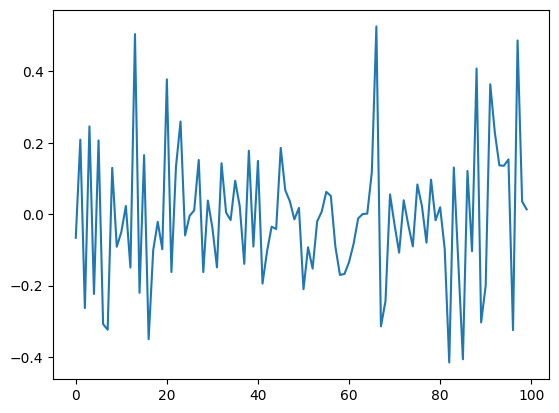

In [11]:
data.X_FULL.shape

plt.plot(data.Y_TS.numpy()[0:100])

In [7]:
data.Y_TS.shape

torch.Size([1000])

In [12]:
from Metrics import MSE
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask, IPDistribution

N_UNITS_LIST = [100, 150, 200, 250]
W_range=(-0.5, 0.5)
initial_rho = 0.5
desired_rhos = [0.95, 0.95, 0.95, 0.95]
bias_range = [-0.1, 0.1]

In [13]:
REPETITIONS = 1
max_epochs = 15 
columns = ["Name", "TYPE", "MSE", "MC", "Lambda max", "delta_phI", "KL", "Rho", "A-Norm", "B-Norm"]
models_num = len(N_UNITS_LIST)*len(desired_rhos)
rows = []

for N_UNITS, desired_rho in zip(N_UNITS_LIST, desired_rhos):
    config_string = f"{N_UNITS} UNIT - Spectral Radius: {desired_rho}"
    names = ["Vanilla", "Gauss 1", "Gauss 2", "Bimodal", "Trim 1", "Trim 2"]
    identifiers = [ f"- {name} - {config_string} " for name in names]
    
    for R in range(REPETITIONS):
        vanilla_reservoir = Reservoir(N = N_UNITS, ro_rescale = desired_rho, W_range=W_range, bias_range=bias_range)
        
        gaussian_reservoir_1 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.5, apply_activation=True))
        gaussian_reservoir_2 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.25, apply_activation=True))

        bimodal_reservoir = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.mixedBimodalMask(N_UNITS, 0.69, 0.92, apply_activation=True))
        
        trimodal_reservoir_1 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.15, 0.92, apply_activation=True))
        trimodal_reservoir_2 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.075, 0.72, apply_activation=False))
        
        print("Traning IP models")
        gaussian_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=True)
        gaussian_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        bimodal_reservoir.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        trimodal_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000005, verbose=False)
        trimodal_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)

        models = [vanilla_reservoir, gaussian_reservoir_1, gaussian_reservoir_2, bimodal_reservoir, trimodal_reservoir_1, trimodal_reservoir_2]

        for model_index in range(len(models)): 
            model = models[model_index]

            esn = EchoStateNetwork(model)
            esn.train(X_TR,Y_TR, 0)

            mse = esn.evaluate(X_TS, Y_TS, metric=MSE()).item()
            
            mc = esn.MemoryCapacity().item()
            
            lambda_max = model.LCE(X_TS)

            de_phi = model.de_fi()

            KL = model.kl_value.item() if model_index != 0 else None
            a_norm = model.a.norm().item() if model_index != 0 else 1
            b_norm = model.b.norm().item() if model_index != 0 else 0

            # columns = ["________________Name____________________","TYPE", "MSE","MC","Lambda max","delta_phI","KL", "Rho", "A-Norm", "B-Norm"]
            rows.append([f"{R+1}) {identifiers[model_index]}" , model_index, mse, mc, lambda_max, de_phi, KL, model.max_eigs().item(), a_norm, b_norm])
            print(rows[-1])

        
        


Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10855521261692047. | Spectral radius: 0.5513198375701904
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.12521995604038239. | Spectral radius: 0.6026560068130493
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.16566121578216553. | Spectral radius: 0.6661125421524048
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.24365203082561493. | Spectral radius: 0.7998213171958923
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.32041239738464355. | Spectral radius: 1.2001535892486572
Too high spectral radius: 1.2001535892486572, rolling back to previous state!
- Epoch: 1) | KL Divergence value: 0.2217775285243988. | Spectral radius: 0.7525407671928406
Epoch: 5) - Safe mode traning - Learning Rate = 6.25e-06
- Ep

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.02682e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.30422e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.26756e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.049179237335920334, 8.462864875793457, -1.785476, 0.08210440152156606, 0.28597167134284973, 0.9489489793777466, 17.47007179260254, 4.659165382385254]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.78067e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.18481e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.21421e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.04881304129958153, 8.13978099822998, -3.2753017, 0.6212492157515712, 0.22024428844451904, 0.9458749890327454, 18.300254821777344, 7.182389736175537]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08175e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.07406e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.06535e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.049076687544584274, 8.181184768676758, -1.9254299, 0.32100872782386203, 0.10878145694732666, 0.9496115446090698, 19.047149658203125, 9.461167335510254]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.64002e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.29636e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.96212e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.049189575016498566, 9.47803020477295, -0.11905424, 0.06017689420145556, 0.07843709737062454, 0.944940984249115, 18.479555130004883, 7.982609748840332]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.04891536384820938, 9.695772171020508, -0.0779439, 0.068226399249381, 0.05829694867134094, 0.9457294940948486, 18.46084213256836, 8.143818855285645]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10576222836971283. | Spectral radius: 0.5511869192123413
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1210273951292038. | Spectral radius: 0.601449191570282
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.15658435225486755. | Spectral radius: 0.6569714546203613
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | K

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.78455e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.00017e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.98867e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 0.049504198133945465, 10.814192771911621, -1.8473761, 0.10162888312689605, 0.2488139420747757, 0.939239501953125, 20.335195541381836, 5.024569988250732]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 0.04980296641588211, 9.19713306427002, -0.6771413, 0.045288681555754856, 0.24210217595100403, 0.9496006369590759, 22.218372344970703, 8.530670166015625]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.18621e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.15735e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08443e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 0.05057188868522644, 8.655501365661621, -0.70823115, 0.1085448369378407, 0.09943089634180069, 0.9483633637428284, 23.385009765625, 11.580246925354004]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 0.04994308203458786, 9.862885475158691, -0.14017676, 0.11298995309314001, 0.0843522921204567, 0.9471177458763123, 20.861940383911133, 9.941070556640625]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 0.04965392127633095, 11.214929580688477, -0.11541937, 0.05052795201498829, 0.05801521614193916, 0.9491782784461975, 19.452672958374023, 8.216118812561035]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10593980550765991. | Spectral radius: 0.5503556132316589
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11913159489631

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.36853e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.08862e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.19928e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 0.049231842160224915, 11.264289855957031, -0.17554648, 0.04626556749004185, 0.22456979751586914, 0.9452505111694336, 22.631807327270508, 5.149173259735107]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 0.0518023855984211, 9.984124183654785, -0.1561296, 0.0893203406547293, 0.23841850459575653, 0.948569118976593, 25.243946075439453, 9.762438774108887]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0121e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.5696e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.10153e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['1) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 0.0930161252617836, 8.95900821685791, -0.08224803, 0.05899506133160262, 0.1057267040014267, 0.9487692713737488, 27.218931198120117, 13.327008247375488]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 0.050579991191625595, 10.897775650024414, -0.08030329, 0.04516632914049805, 0.08881623297929764, 0.9485344886779785, 24.38130760192871, 11.054834365844727]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 0.050070490688085556, 11.563741683959961, -0.075173795, 0.0503200640252677, 0.06174721196293831, 0.9396829605102539, 25.662391662597656, 11.539850234985352]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10630649328231812. | Spectral radius: 0.5517258048057556
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11770886

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.44369e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69181e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.69306e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 0.05168028175830841, 11.570069313049316, -1.1364738, 0.06185255559432789, 0.2547164857387543, 0.9482715129852295, 27.942787170410156, 7.178782939910889]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 0.05345014110207558, 10.097922325134277, -0.18107164, 0.1453591043707891, 0.229842409491539, 0.9462862610816956, 25.756839752197266, 9.822630882263184]
Reservoir warmed up with the first 100 time steps
['1) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 0.05209532752633095, 10.09116268157959, -1.6012232, 0.06189904717168211, 0.10663414001464844, 0.9489260315895081, 30.14898109436035, 15.107034683227539]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 0.05224865674972534, 10.908905982971191, -0.16158593, 0.07252293486614378, 0.08948783576488495, 0.9482551217079163, 31.073440551757812, 13.829347610473633]
Reservoir war

In [14]:
import pandas as pd 
df = pd.DataFrame(rows)
df.to_csv("./7_RESULTS_VerstraetenDambre.csv", header=columns)

In [15]:
df = pd.DataFrame(rows, columns=columns)

In [2]:
import pandas as pd 

In [4]:
df = pd.read_csv("./RESULTS/7_RESULTS_VerstraetenDambre.csv")

In [5]:
df

,Unnamed: 0,Name,TYPE,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
0,0,1) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,0.047673,18.497938,-0.103597,0.053663,NaN,0.950000,1.000000,0.000000
1,1,1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95,1,0.049179,8.462865,-1.785476,0.082104,0.285972,0.948949,17.470072,4.659165
2,2,1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95,2,0.048813,8.139781,-3.275302,0.621249,0.220244,0.945875,18.300255,7.182390
3,3,1) - Bimodal - 100 UNIT - Spectral Radius: 0.95,3,0.049077,8.181185,-1.925430,0.321009,0.108781,0.949612,19.047150,9.461167
4,4,1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95,4,0.049190,9.478030,-0.119054,0.060177,0.078437,0.944941,18.479555,7.982610
5,5,1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95,5,0.048915,9.695772,-0.077944,0.068226,0.058297,0.945729,18.460842,8.143819
6,6,1) - Vanilla - 150 UNIT - Spectral Radius: 0.95,0,0.049314,19.442188,-0.149194,0.100916,NaN,0.950001,1.000000,0.000000
7,7,1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95,1,0.049504,10.814193,-1.847376,0.101629,0.248814,0.939240,20.335196,5.024570
8,8,1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95,2,0.049803,9.197133,-0.677141,0.045289,0.242102,0.949601,22.218372,8.530670
9,9,1) - Bimodal - 150 UNIT - Spectral Radius: 0.95,3,0.050572,8.655501,-0.708231,0.108545,0.099431,0.948363,23.385010,11.580247


: 

In [16]:
df.groupby("TYPE").mean()

,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
TYPE,,,,,,,,
0,0.049654,21.440380,-0.125018,0.064085,NaN,0.950001,1.000000,0.000000
1,0.049899,10.527854,-1.236218,0.072963,0.253518,0.945428,22.094965,5.502923
2,0.050967,9.354740,-1.072411,0.225304,0.232652,0.947583,22.879853,8.824532
3,0.061190,8.971714,-1.079283,0.137612,0.105143,0.948918,24.950018,12.368864
4,0.050490,10.286899,-0.125280,0.072714,0.085273,0.947212,23.699061,10.701966
5,0.049840,10.992300,-0.095089,0.149068,0.059411,0.946076,23.001382,10.178203
